by Andreas Bauer and David Boehringer, 19.06.2020
This script contains two examples for 3D-PIV: The shift of a bar of binary pixels in one direction, the expansion
and a real data set where we recorded two stacks of collagen fibres at the same field of view with confocal microscopy
 in reflection mode.  One stack contains a NK cell that deforms the matrix and the other doe not.
Please download the data at https://github.com/fabrylab/3D_piv_example_data.git (180 MB, unpacked) and provide the
folder in the code below.
We tested this on ubuntu 16 and 18, with Anaconda Python installation. The whole script
takes about 5 minutes on my 4 core-intel i5 @2.5 GHz Laptop. You should have !!! 8 Gb ob Memory !!!! or take care not
to open  all matplotlib plots as interactive windows at once.
For questions contact andreas.b.bauer@fau.de


In [4]:
from openpiv.pyprocess3D import *
from openpiv.PIV_3D_plotting import *
from openpiv.pyprocess3D import extended_search_area_piv3D
from openpiv.validation import sig2noise_val
from openpiv.filters import replace_outliers
from openpiv.lib import replace_nans
import os
from natsort import natsorted
import matplotlib.animation as animation

Make save_plots = True if you want to compare the 
visual results 

In [5]:
save_plots = False
out_put_folder = "output_3D_test"
if save_plots:
    if not os.path.exists(out_put_folder):
        try:
            os.mkdir(out_put_folder)
        except:
            print("could not generate output folder")
            save_plots = False

############ a group of bars shifted by 1 pixel to the each dimesion the second frame #############
takes ~4 seconds

In [6]:
# constructing frame 1 and frame 2
size = (32, 32, 32)
shape1 = np.zeros(size)
shape2 = np.zeros(size)

In [7]:
shape1[16, 16, 25:27] = 1
shape1[16, 16, 7:9] = 1
shape1[16, 25:27, 16] = 1
shape1[16, 7:9, 16] = 1
shape1[25:27, 16, 16] = 1
shape1[7:9, 16, 16] = 1

In [8]:
shape2[16, 16, 24:26] = 1
shape2[16, 16, 8:10] = 1
shape2[16, 24:26, 16] = 1
shape2[16, 8:10, 16] = 1
shape2[24:26, 16, 16] = 1
shape2[8:10, 16, 16] = 1

In [9]:
window_size = (4, 4, 4)
overlap = (3, 3, 3)
search_area = (5, 5, 5)

In [10]:
u, v, w, sig2noise = extended_search_area_piv3D(shape1, shape2, window_size=window_size, overlap=overlap,
                                                search_area_size=search_area, subpixel_method='gaussian',
                                                sig2noise_method='peak2peak',
                                                width=2)

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<00:00, 78.05it/s]


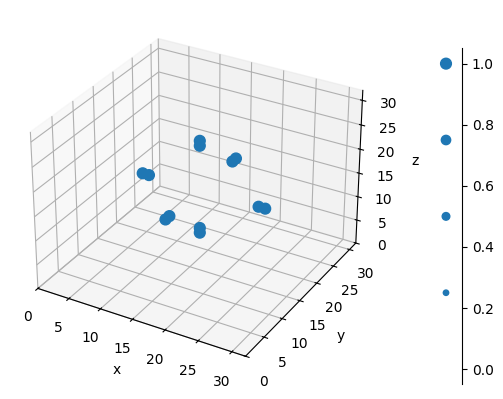

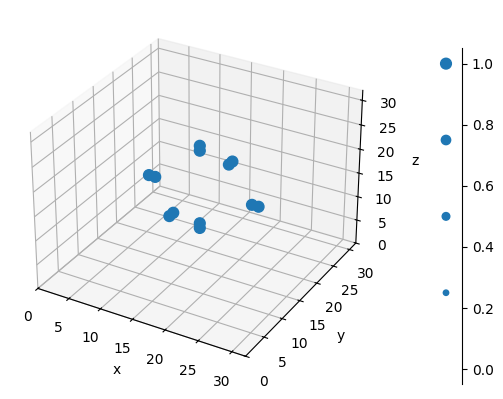

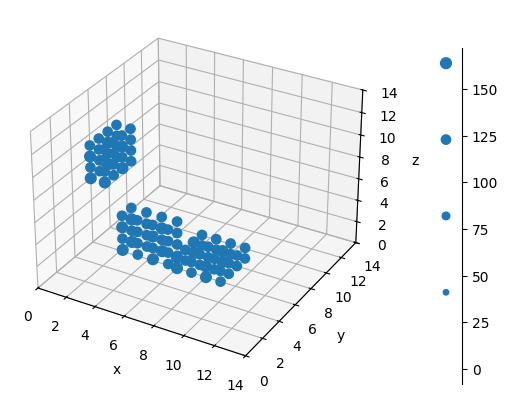

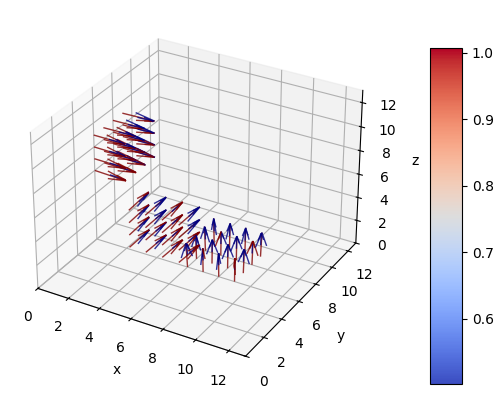

In [11]:
# displaying the shapes with 3D scatter plot
fig1 = scatter_3D(shape1, control="size")
fig2 = scatter_3D(shape2, control="size")
# 3d plot of the signal-to-noise rations
fig3 = scatter_3D(sig2noise, control="size", cmap = "coolwarm")
# 3d quiver plot of the displacement field
fig4 = quiver_3D(-u, v, w, cmap="coolwarm", quiv_args={"arrow_length_ratio":0.6})

In [12]:
# saving the plots
if save_plots:
    fig1.savefig(os.path.join(out_put_folder, "displaced_bar_frame1.png"))
    fig2.savefig(os.path.join(out_put_folder, "displaced_bar_frame2.png"))
    fig3.savefig(os.path.join(out_put_folder, "displaced_bar_sig2noise.png"))
    fig4.savefig(os.path.join(out_put_folder, "displaced_bar_deformation_field.png"))

################### test to check the replace_nans_function ######################
takes ~4 seconds

In [13]:
# ball shape with a gap of nans in the middle
center = (5, 5, 5)
size = (10, 10, 10)
distance = np.linalg.norm(np.subtract(np.indices(size).T, np.asarray(center)), axis=len(center))
arr = np.ones(size) * (distance <= 5)
hide = arr == 0
arr[5:7] = np.nan

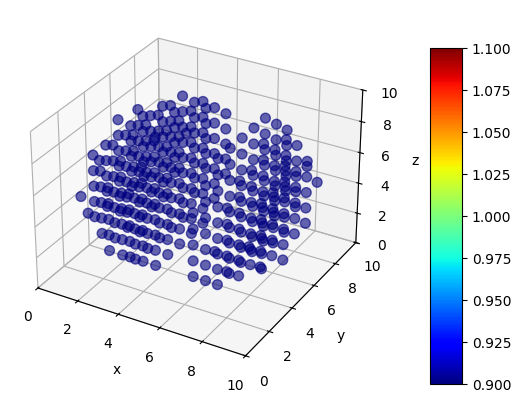

In [14]:
# displaying in 3d plots. Values outside of the original ball are hidden by setting to nan
arr_show = arr.copy()
arr_show[hide] = np.nan
fig9 = scatter_3D(arr_show, size=50, sca_args={"alpha": 0.6})
# replacing outliers
arr = replace_nans(arr, max_iter=2, tol=2, kernel_size=2, method='disk')

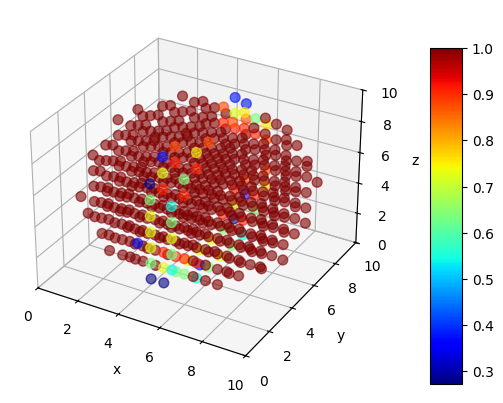

In [15]:
# displaying in 3d plots. Values outside of the original ball are hidden by setting to nan
arr_show = arr.copy()
arr_show[hide] = np.nan
fig10 = scatter_3D(arr_show, size=50, sca_args={"alpha": 0.6})

In [16]:
# saving the plots
if save_plots:
    fig9.savefig(os.path.join(out_put_folder, "replace_nan_gap.png"))
    fig10.savefig(os.path.join(out_put_folder, "replace_nan_filled.png"))

#################### real data example ############################

we recorded stacks of collagen fibres with confocal microscopy in reflection mode
"alive" stack contains a force generating NK-cell, marked by the red circle in the animation
"relaxed" stack is the same field of view with out the cell
download the data at https://github.com/fabrylab/3D_piv_example_data.git
this calculation takes ~ 3-4 minutes on my 4-core Intel i5@2.5 GHz Laptop

In [17]:
# please enter the path to the dataset provided at
folder = r"test_3d"

In [19]:
if not os.path.exists(folder): 
    import git 
    repo = git.Repo.clone_from("https://github.com/fabrylab/3D_piv_example_data.git", './test_3d', branch='master')

In [21]:
if not os.path.exists(folder):
    raise FileNotFoundError("path to 3d piv data '%s' does not exists\n"
                            ". Please download the data from https://github.com/fabrylab/3D_piv_example_data.git" % folder)
# stack properties
# factors for voxel size
du = 0.2407
dv = 0.2407
dw = 1.0071
# total image dimension for x y z
image_dim = (123.02, 123.02, 122.86)

In [22]:
# keep these values for our nk cells stacks
win_um = 12  # window size in µm
fac_overlap = 0.3  # overlap in percent of the window size
signoise_filter = 1.3

In [23]:
# window size for stacks in pixel
window_size = (int(win_um / du), int(win_um / dv), int(win_um / dw))
overlap = (int(fac_overlap * win_um / du), int(fac_overlap * win_um / dv), int(fac_overlap * win_um / dw))
search_area = (int(win_um / du), int(win_um / dv), int(win_um / dw))

In [24]:
# load tense stacks
import glob
images = natsorted(glob.glob(os.path.join(folder, "Series001_t22_z*_ch00.tif")))
im_shape = plt.imread(images[0]).shape
alive = np.zeros((im_shape[0], im_shape[1], len(images)))
for i, im in enumerate(images):
    alive[:, :, i] = plt.imread(im)

In [25]:
# load relaxed stack
images = natsorted(glob.glob(os.path.join(folder, "Series003_t05_z*_ch00.tif")))
im_shape = plt.imread(images[0]).shape
relax = np.zeros((im_shape[0], im_shape[1], len(images)))
for i, im in enumerate(images):
    relax[:, :, i] = plt.imread(im)

In [26]:
# 3D PIV
u, v, w, sig2noise = extended_search_area_piv3D(relax, alive, window_size=window_size, overlap=overlap,
                                                search_area_size=search_area, dt=(1 / du, 1 / dv, 1 / dw),
                                                subpixel_method='gaussian',
                                                sig2noise_method='peak2peak',
                                                width=2)

100%|██████████| 14/14 [02:25<00:00, 10.37s/it]


In [27]:
# correcting stage drift between the field of views
u -= np.nanmean(u)
v -= np.nanmean(v)
w -= np.nanmean(w)

In [28]:
# filtering
mask = sig2noise_val(sig2noise, threshold=signoise_filter)
uf, vf, wf = replace_outliers(u, v, mask, w=w, max_iter=1, tol=100, kernel_size=2, method='disk')

In [29]:
# plotting
# representation of the image stacks by maximums projections. The red circle marks the position of the cell
def update_plot(i, ims, ax):
    a1 = ax.imshow(ims[i])
    a2 = ax.add_patch(plt.Circle((330, 140), 100, color="red", fill=False))
    return [a1, a2]

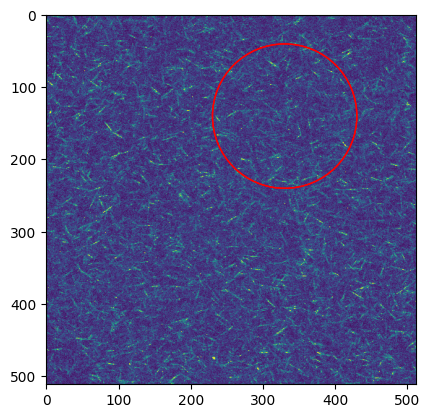

In [30]:
ims = [np.max(relax[:, :, 60:], axis=2), np.max(alive[:, :, 60:], axis=2)]
fig = plt.figure()
ax = plt.gca()
ani = animation.FuncAnimation(fig, update_plot, 2, interval=200, blit=True, repeat_delay=0, fargs=(ims, ax))

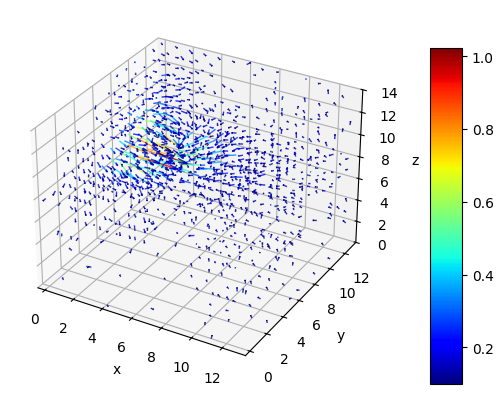

In [31]:
# unfiltered 3d deformation field
fig11 = quiver_3D(-u, v, w, quiv_args={"length": 2, "alpha": 0.8, "linewidth": 1}, filter_def=0.1)

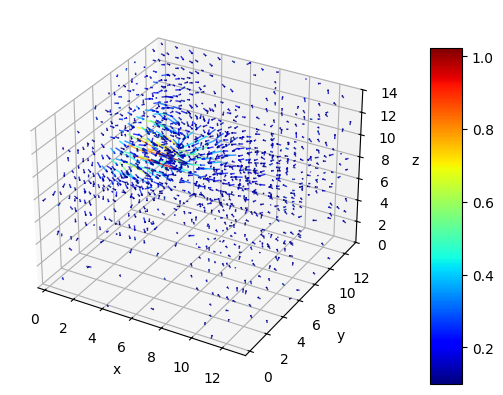

In [32]:
# filtered 3d deformation field
fig12 = quiver_3D(-uf, vf, wf, quiv_args={"length": 2, "alpha": 0.8, "linewidth": 1},
                  filter_def=0.1)

In [33]:
# saving the plots
if save_plots:
    fig11.savefig(os.path.join(out_put_folder, "real_data_unfiltered.png"))
    fig12.savefig(os.path.join(out_put_folder, "real_data_filtered.png"))

    # This needs a working ImageMagick installation, and probably works only on linux
    try:
        import imageio
        plt.ioff()
        f1 = plt.figure()
        plt.imshow(ims[0])
        plt.gca().add_artist(plt.Circle((330, 140), 100, color="red", fill=False))
        f1.savefig(os.path.join(out_put_folder,"tem1.png"))

        f2 = plt.figure()
        plt.imshow(ims[1])
        plt.gca().add_artist(plt.Circle((330, 140), 100, color="red", fill=False))
        f2.savefig(os.path.join(out_put_folder,"tem2.png"))

        i1 = plt.imread(os.path.join(out_put_folder,"tem1.png"))
        i2 = plt.imread(os.path.join(out_put_folder, "tem2.png"))
        imageio.mimsave(os.path.join(out_put_folder, "reaL_data_max_proj.gif"),[i1,i2], fps=1)
        os.remove(os.path.join(out_put_folder,"tem1.png"))
        os.remove(os.path.join(out_put_folder,"tem2.png"))
        plt.ion()
    except Exception as e:
        print ("failed to write gif of collagen embedded cell:")
        print(e)